# Battle of the Neighborhoods
## Model_continuous

__Table of Contents__

* [Train-test split](#Train-test-split)
* [Feature-selection](#Feature-selection)
* [Linear regression](#Linear-regression)
* [Single Layer Perceptron](#Single-Layer-Perceptron)
* [Multi Layer Perceptron](#Multi-Layer-Perceptron)
* [Summary](#Summary)

![](https://vignette.wikia.nocookie.net/phineasandferb/images/9/9b/Treehouse_Fight.jpg/revision/latest?cb=20090320212850)

# For a __Brand New Sports Facility__ in Hyderabad, India


__The story so far...__

In the notebook 'intro_data.ipynb', the [motivation](intro_data.ipynb#Introduction) for building a sports facility was outlined. [Data](intro_data.ipynb#Data) was also collected using Google Place API, and stored in JSON files. This data was collected for ten venue categories:
[Sports facilities, cinemas, pubs, gyms, banks, hospitals, supermarkets, schools, colleges, and restaurants](intro_data.ipynb#Points-of-interest-in-Hyderabad).

In 'preprocessing.ipynb', a large dataset of locations was built. The locations of existing sports facilities was supplemented with locations chosen randomly (uniformly) from the city. For all of these locations, the distances to ten nearest venues for each of the ten venue categories was calculated. This distance data was cast to a pandas DataFrame and subsequently stored to disk to the file 'fullDataset.json'.

In 'model_binary.ipynb', the dataset was used to train simple logistic regression models. Proximity to the closest sports venue was used as the suitability score, and then thresholded to obtain class labels - either suitable or unsuitable. The class imbalance in the data turned out to be a problem with binary classifiers. Trying to balance the data made things a bit too messy.

$~$

__In this notebook...__

The suitability score (proximity to nearest sports venue) is used as the continuous target value. This is done to avoid class imbalance and to train directly against the suitability score instead of having to classify locations. We try a simple linear regression model and a few feedfoward neural networks (Single Layer Perceptrons and Multi Layer Perceptrons).  

__In the next notebook...__

We do away with suitability scores and do clustering instead. The aim is to see if the locations for all of the existing sports facilities fall nicely into one or a few clusters, separated from most of the other locations. We will not do any fancy clustering - just simple K-means with a few random initial seed. Because this project has already taken me much longer than I hoped it would. 


In [21]:
import json
import numpy as np
import pandas as pd
import time # Will use sleep from time to pause 
import matplotlib.pyplot as plt
import folium

from warnings import warn
%matplotlib inline

In [22]:
df_full = pd.read_json('fullDataset.json')
venueCats = ["sports", "cinemas", "pubs", "gyms", "banks", 
             "hospitals", "supermarkets", "schools", "colleges", "restaurants"]
venueCats = sorted(venueCats, key=str.lower)

# Because we consider distances to other venues when defining features
# and distance to sports facilities when defining output labels and scores
venueCats_sans_sports = venueCats.copy()
venueCats_sans_sports.remove('sports')

# Location of the center of the city: 
# The location of the "Buddha Statue" in a lake called "Hussain Sagar" at the center of the city is used
latCC = lat_CC = 17.415435
lngCC = lng_CC = 78.474296

df_full.reset_index(drop=True, inplace=True)

print(venueCats)
print(df_full.columns[3:].values)

['banks', 'cinemas', 'colleges', 'gyms', 'hospitals', 'pubs', 'restaurants', 'schools', 'sports', 'supermarkets']
['banks' 'cinemas' 'colleges' 'gyms' 'hospitals' 'pubs' 'restaurants'
 'schools' 'sports' 'supermarkets']


In [23]:
n_nbrs = len(df_full.iloc[0,5])  
print("Using n_nbrs:",n_nbrs)
df_full.head()

Using n_nbrs: 10


,Location,Latitude,Longitude,banks,cinemas,colleges,gyms,hospitals,pubs,restaurants,schools,sports,supermarkets
0,"[17.5333915503, 78.3019480094]",17.533392,78.301948,"[0.5944527837, 0.9123336302, 1.1945137594, 1.2...","[2.5226926821999998, 2.7441248317999998, 3.292...","[2.2231445958, 2.4326837456, 2.5586923999, 2.6...","[0.4141267293, 0.6469971331000001, 1.470688927...","[2.4209027735, 2.6356289195000002, 2.651096537...","[0.4326443585, 2.0161228142, 2.0193793055, 2.0...","[2.8365380395, 2.8365380395, 3.6162430067, 4.7...","[0.3709854836, 0.5719475071, 0.5819651468, 0.6...","[0.9887859477000001, 1.5864883539, 1.615919187...","[1.5239640962, 2.0930682862, 2.4115800549, 2.6..."
1,"[17.4942544, 78.1426446]",17.494254,78.142645,"[0.6754174845, 0.6909662965000001, 0.746231804...","[4.2429786787, 4.5061204992, 7.7483776384, 8.4...","[0.1316769686, 1.8442535139, 3.9067855433, 3.9...","[0.14670746310000002, 1.0841352373, 1.67283942...","[3.8287129508, 4.5275674007, 4.5310875347, 4.5...","[4.5335069359, 4.7413597513, 8.7463913996, 8.9...","[10.3520028636, 16.9519428463, 16.9519428463, ...","[0.5237399309, 0.5316808758, 0.924419337700000...","[0.0, 0.018022444000000002, 0.0319378584, 0.96...","[13.9095550906, 13.9142012707, 14.3331331326, ..."
2,"[17.2736776385, 78.5670567671]",17.273678,78.567057,"[2.2614932277, 2.2624956284, 2.2690632559, 2.2...","[6.4672878001, 6.9237351057000005, 6.956319766...","[1.2465647364, 1.7114100722, 1.9511505964, 2.0...","[1.9511606865000002, 2.1844757094, 2.228745610...","[5.5789316488, 6.0012584187, 6.064016701, 6.44...","[1.2535245812, 3.3873357157, 3.7890114492, 5.2...","[6.7748896167, 7.4194043843, 7.4250739684, 7.4...","[0.9387879407, 1.1159395825, 1.1597221395, 1.2...","[1.6722465827000002, 2.8126944449, 2.976785561...","[2.2234366467, 5.2608094770000005, 5.279426647..."
3,"[17.2159971208, 78.5018378083]",17.215997,78.501838,"[1.0231317789, 1.0290610733, 1.552344901600000...","[2.8466319478, 7.118468551, 11.137838919, 11.4...","[2.667688001, 2.7771837433, 2.8335145658, 2.84...","[0.8044426591, 0.9004906079, 2.6654642685, 2.7...","[11.6441161148, 11.821180716, 12.5591125675, 1...","[5.8143442376, 7.8437278947, 7.905480393599999...","[3.6821682024999998, 7.8654203973, 7.942906800...","[0.9962343093, 1.0744389745, 1.902801744, 2.60...","[0.6524729677000001, 2.9911387450999998, 4.248...","[4.7284731381, 10.1528607584, 11.1395369905, 1..."
4,"[17.5405338, 78.3857611]",17.540534,78.385761,"[0.17909229840000002, 0.773952089, 1.214674442...","[4.1980559378, 4.278676515, 4.278676515, 4.480...","[0.17714835180000002, 0.2923846075, 0.76939061...","[0.9023824009, 1.5523972775, 1.5571471251, 2.0...","[2.720175495, 4.302153125, 4.3027458242, 4.588...","[2.2791124241, 3.0928239586, 3.8176102177, 3.8...","[2.2898091591, 3.0622868938, 3.2388035882, 4.5...","[0.0762680701, 0.28190401390000003, 0.36464936...","[0.0, 0.0231518678, 0.0493814418, 0.0514730139...","[2.2811736948, 2.2908107154, 2.2976849177, 2.3..."


In [24]:
# Convert all distance lists in df_full to numpy arrays
df_full.loc[:,venueCats] = df_full.loc[:,venueCats].applymap(lambda x: np.array(x))
type(df_full.iloc[0,4])

numpy.ndarray

# Train-test split

Let's use 10% for testing. 10% puts the number of testing datapoints at 800, which is a decent number of points.

In [25]:
from sklearn.model_selection import train_test_split
test_size = 0.1

df_train, df_test = train_test_split(df_full, test_size=test_size,random_state=0)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
print(len(df_train), len(df_test))
# Check to make sure that these are pandas dataframes
df_train.head()

7227 803


,Location,Latitude,Longitude,banks,cinemas,colleges,gyms,hospitals,pubs,restaurants,schools,sports,supermarkets
0,"[17.5261463694, 78.6276052594]",17.526146,78.627605,"[1.1910578882, 2.3531500648, 2.8422613385, 3.7...","[3.8080600188, 3.880950221, 4.6192567462, 4.61...","[0.7143162385, 0.7161157994, 0.720318063800000...","[1.6406338103, 3.8926011936, 4.2390121412, 4.3...","[2.285952825, 6.0126362675, 6.6448280745, 7.92...","[1.3274757278, 4.7781594108, 4.9757089922, 4.9...","[7.0065596931, 8.6121227002, 8.6704252244, 8.7...","[0.8682600604, 1.4718778649, 1.502702441, 1.86...","[0.7575276609, 0.8078827149000001, 0.808729543...","[4.4526784487, 4.4526784487, 4.6963936487, 4.6..."
1,"[17.4896164664, 78.5875253239]",17.489616,78.587525,"[0.5046672785, 0.9959750281, 1.098482708, 1.10...","[1.3856085387000001, 1.3856085387000001, 2.075...","[1.1456593896, 1.2360172398, 1.2691097698, 1.3...","[0.5583676247, 1.0898644747, 1.0938081437, 1.2...","[1.1833596464, 2.3888138403, 2.4049978613, 2.4...","[0.7666721712, 1.0510152815, 1.266574856600000...","[1.186694115, 2.7852363335, 3.4320192253, 3.43...","[0.4309211354, 0.5527315308, 0.5540815468, 0.6...","[0.191959, 0.9968841887000001, 1.3476322072, 1...","[0.6596358787000001, 1.1862386071, 1.190026921..."
2,"[17.4584430135, 78.3858941153]",17.458443,78.385894,"[0.6614147295, 0.9183693181, 0.9243992465, 0.9...","[0.1226588088, 0.6658709516, 0.978313008900000...","[0.2378676964, 0.40345462060000004, 0.76360035...","[0.23238174390000002, 0.6549283723, 0.92749517...","[0.9857354936, 1.4575890019, 1.5033332981, 2.0...","[0.5772582883, 0.8007587541000001, 0.858765659...","[1.0950257596, 1.0974015758, 1.1524645376, 1.3...","[1.1475787796999999, 1.1587734907, 1.188857435...","[0.23238174390000002, 0.2351670223, 0.34204898...","[1.3389279973, 1.3730875276, 1.486202633, 1.61..."
3,"[17.2098955955, 78.2551144749]",17.209896,78.255114,"[4.6863408451, 5.142751971, 5.7310288261, 6.08...","[15.093369544, 15.3850924384, 15.4836151877, 1...","[4.8113402658, 7.3866685385, 7.9082040042, 7.9...","[7.1227889439, 7.4131857985, 7.7316160541, 8.5...","[7.7238078534, 7.7447642134, 7.9383691764, 8.1...","[8.5401378411, 10.7018630694, 14.3107583072, 1...","[14.7280597754, 15.012382467, 15.0239117883, 1...","[1.8165287912, 2.1198085173, 2.6493099229, 2.9...","[7.1532318737, 7.9480794796000005, 9.214021691...","[6.1061942507, 15.2640151772, 15.8625349948, 1..."
4,"[17.5933735913, 78.6461721681]",17.593374,78.646172,"[3.0000181358, 3.7973513772, 3.9957430046, 3.9...","[5.2367769465, 6.7092104902, 7.9029192477, 7.9...","[0.5844938355, 3.140211194, 3.3731424611, 3.43...","[7.9440239155, 8.013034184, 8.0202853444, 9.00...","[5.4448750133, 10.6512842024, 13.5323509883, 1...","[4.9253467588, 6.4018387935, 8.1228470829, 9.6...","[14.292169597000001, 15.5484860745, 15.6553784...","[3.4885486375, 3.5265950575, 3.9895825396, 4.1...","[3.8898353197, 3.8958615290000003, 8.255870867...","[9.3766983373, 9.3797909069, 9.3935589528, 11...."


In [26]:
df = df_train # Makes life easier

# Feature selection

__See the notebook model_binary.ipynb for a discussion on features and output labels.__

In [27]:
proximityFun = lambda dist : (1.)/(1.+(dist/0.5))

# First, define a function that takes venue category and location as input,
#    and returns an associated feature (scalar or vector)
# Then, we build a class of such functions

def dist_n(dfTmp, venueCat, n=2):
    """ Returns distance to (n+1)^th closest venue of category venueCat for all locations in dfTmp. n Defaults to 2.
    n can take values 0 to n_nbrs-1 (inclusive). """
    return dfTmp[venueCat].apply(lambda x: x[n]).to_numpy().reshape((-1,1))

def prox_n(dfTmp, venueCat, n=2):
    """ Returns proximity to (n+1)^th closest venue of category venueCat for all locations in dfTmp. 
    n defaults to 2. 
    n can take values 0 to n_nbrs-1 (inclusive) """
    return dfTmp[venueCat].apply(lambda x: proximityFun(x[n]) ).to_numpy().reshape((-1,1))

def dist_0_n(dfTmp, venueCat, n=2):
    """ Returns distance to 1st to (n+1)^th closest venue of category venueCat for all locations in dfTmp. n Defaults to 2.
    n can take values 0 to n_nbrs-1 (inclusive). """
    n = min(n,n_nbrs-1)
    return np.array(dfTmp[venueCat].apply(lambda x: x[:n+1] ).to_list()).reshape((-1,n+1))
    

def prox_0_n(dfTmp, venueCat, n=2):
    """ Returns proximity to 1st to (n+1)^th closest venue of category venueCat for all locations in dfTmp. 
    n defaults to 2. 
    n can take values 0 to n_nbrs-1 (inclusive) """
    n = min(n,n_nbrs-1)
    return np.array(dfTmp[venueCat].apply(lambda x: proximityFun(np.array(x[:n+1]) ) ).to_list()).reshape((-1,n+1))


def featureVector(dfTmp,featureFun=prox_n, **kwargs):
    """ Returns vector containing features associated to a location 
    Positional arguments:
        lat : Latitude
        lng : Longitude
    Keyword arguments:
        featureFun : Callable that takes arguments (venueCat, **kwargs) to define features
                        Defaults to feature_prox_n                    
        **kwargs : Passed directly to featureFun
    
    Returns:
        featureVec : pd.Series of shape (m*N,), where m is number of floats returned by featureFun,
                        N is len(venueCats)-1
    """
    assert venueCats_sans_sports == sorted(venueCats_sans_sports, key=str.lower)  
    # Ensure venueCats_sans_sports properly ordered
    
       
    featureArr0 = featureFun(dfTmp,venueCats_sans_sports[0], **kwargs) # Features for category 0
    assert isinstance(featureArr0, np.ndarray) and featureArr0.ndim == 2
    m = featureArr0.shape[1]
    featureArr = np.zeros( (len(dfTmp), m * (len(venueCats_sans_sports)) ) )  # Initialize array for all cats,except sports
    featureArr[:,:m] = featureArr0 # Assign features for cat 0
    
    # Assign features for other categories
    for index in range(1, len(venueCats_sans_sports)):
        featureArr[:,index * m : (index+1) * m ] = featureFun(dfTmp,
                                venueCats_sans_sports[index], **kwargs)
    
    return featureArr

def featureVector_small(dfTmp,vCats_small, featureFun=prox_n, **kwargs):
    """ Returns vector containing features associated with locations in dfTmp
    Positional arguments:
        dfTmp: DataFrame containing distances to n_nbrs nearest neighbors
        vCats_small: A subset of venueCats to use a limited set of features
    Keyword arguments:
        featureFun : Callable that takes arguments (venueCat, **kwargs) to define features
                        Defaults to feature_prox_n                    
        **kwargs : Passed directly to featureFun
    
    Returns:
        featureVec : np.ndarray of shape ( len(dfTmp), m*N ), where m is number of floats returned by featureFun,
                        N is len(venueCats)-1
    """
    assert vCats_small == sorted(vCats_small, key=str.lower)  
    # Ensure venueCats_sans_sports properly ordered
    
       
    featureArr0 = featureFun(dfTmp,vCats_small[0], **kwargs) # Features for category 0
    assert isinstance(featureArr0, np.ndarray) and featureArr0.ndim == 2
    m = featureArr0.shape[1]
    featureArr = np.zeros( (len(dfTmp), m * (len(vCats_small)) ) )  # Initialize array for all cats,except sports
    featureArr[:,:m] = featureArr0 # Assign features for cat 0
    
    # Assign features for other categories
    for index in range(1, len(vCats_small)):
        featureArr[:,index * m : (index+1) * m ] = featureFun(dfTmp,
                                vCats_small[index], **kwargs)
    
    return featureArr


def labelArr(dfTmp):
    return prox_n(dfTmp, 'sports',n=0).flatten()


In [28]:
def clamp(x): 
  return max(0, min(x, 255))

def rgb2hex(r,g,b):
    return "#{0:02x}{1:02x}{2:02x}".format(clamp(r), clamp(g), clamp(b))

def blueRed(x):
    assert 0<= x <= 1
    if x <= 0.5:
        r = int(512*x)
        b = 256
        g = int(512*x)
    else :
        r = 256
        b = int((1.-x)*512)
        g = int((1.-x)*512)
    return rgb2hex(r,g,b)

# Plot first 100 locations in dataset
map_tmp = folium.Map(
    location=[lat_CC, lng_CC], zoom_start=11)

y = labelArr(df)
for ind in range(100):
    folium.CircleMarker(
        [df.iloc[ind,1], df.iloc[ind,2]],
        radius=3,
        fill=True,
        fill_color=blueRed(y[ind]),
        color = blueRed(y[ind]),
        fill_opacity=0.7).add_to(map_tmp)

print("Colormap: blue for S=0, red for S= 1")    
map_tmp

Colormap: blue for S=0, red for S= 1


# Linear Regression

We'll look at two metrics : Mean Squared Error and R Squared. We'll use Lasso regression, hoping that some features would drop out later. 

Before doing a sweep over different feature functions and parameters, let's take a quick peek at what the model would produce. 

### A simple case

In [29]:
from sklearn.linear_model import Lasso
featFun = prox_n; n = 5
X = featureVector(df_train, featureFun=featFun, n=n)
y = labelArr(df_train)

linearModel = Lasso(alpha=0.01).fit(X,y) # Don't do much regularization.

coeffs = [linearModel.intercept_] + list(linearModel.coef_.flatten())
print(tuple(zip(['intercept']+venueCats_sans_sports, coeffs)))

X_test = featureVector(df_test, featureFun=featFun, n=n)
y_test = labelArr(df_test)
print("R2 score:", linearModel.score(X,y))

(('intercept', 0.18935745404568982), ('banks', 0.0332086949735053), ('cinemas', 0.0), ('colleges', 0.0), ('gyms', 0.7257303119117712), ('hospitals', 0.0), ('pubs', 0.0), ('restaurants', 0.0), ('schools', 0.0), ('supermarkets', 0.0))
R2 score: 0.315891024280916


That's a fairly low R2 score, which is bad. Most of the coefficients are zero though. 

Let's see what the errors look like. 

Predictions on training set...


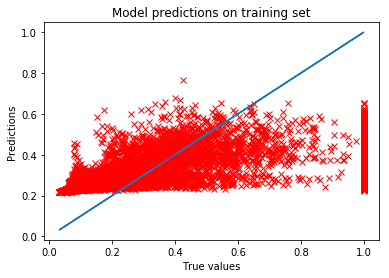

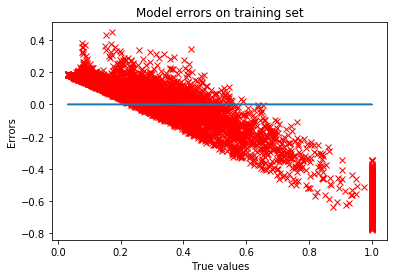

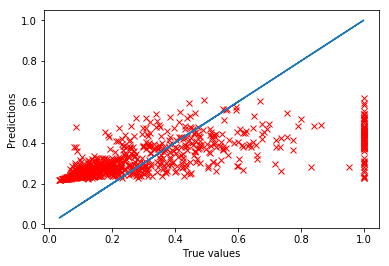

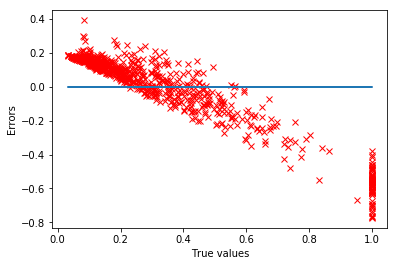

In [30]:
print("Predictions on training set...")
predictions = linearModel.predict(X)
plt.plot(y, predictions, 'rx')
plt.plot(y, y)
plt.title("Model predictions on training set")
plt.xlabel("True values"); plt.ylabel("Predictions")
plt.show()

plt.plot(y, predictions-y, 'rx')
plt.plot(y, 0.*y)
plt.xlabel("True values"); plt.ylabel("Errors")
plt.title("Model errors on training set")
plt.show()



predictions = linearModel.predict(X_test)
plt.plot(y_test, predictions, 'rx')
plt.plot(y_test, y_test)
plt.xlabel("True values"); plt.ylabel("Predictions")
plt.show()


plt.plot(y_test, predictions-y_test, 'rx')
plt.plot(y_test, 0.*y_test)
plt.xlabel("True values"); plt.ylabel("Errors")
plt.show()


The errors aren't normally distributed. There is a clear bias. The culprit here is the large number of datapoints that have near zero true labels. This is pretty much the same problem we had with the binary classifier.

Ideally, I should return to the data collection step and use a different strategy to collect datapoints. Using uniformly distributed random points is bound to produce a lot more "unsuitable locations" than suitable ones. I don't want to go back to do all of that. 

I will pretend that this is one of those cases where the available data is all I have and there's no way to modify or supplement it. This is a common thing to happen. Scikit-learn's logistic regression helps deal with unbalanced data by weighting minority classes by some factor. Unfortunately, the linear regression module doesn't have this kind of weighting. So, I will do this myself. I'll not do anything fancy. Just duplicate the entries with high suitability. That nudges the algorithm towards that end of the data. 

I will duplicate entries only in the training dataset. Let's see how it goes. 


In [31]:
df_train['score'] = labelArr(df_train)
df_train.head()

C:\Users\Sabarish\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Location,Latitude,Longitude,banks,cinemas,colleges,gyms,hospitals,pubs,restaurants,schools,sports,supermarkets,score
0,"[17.5261463694, 78.6276052594]",17.526146,78.627605,"[1.1910578882, 2.3531500648, 2.8422613385, 3.7...","[3.8080600188, 3.880950221, 4.6192567462, 4.61...","[0.7143162385, 0.7161157994, 0.720318063800000...","[1.6406338103, 3.8926011936, 4.2390121412, 4.3...","[2.285952825, 6.0126362675, 6.6448280745, 7.92...","[1.3274757278, 4.7781594108, 4.9757089922, 4.9...","[7.0065596931, 8.6121227002, 8.6704252244, 8.7...","[0.8682600604, 1.4718778649, 1.502702441, 1.86...","[0.7575276609, 0.8078827149000001, 0.808729543...","[4.4526784487, 4.4526784487, 4.6963936487, 4.6...",0.397606
1,"[17.4896164664, 78.5875253239]",17.489616,78.587525,"[0.5046672785, 0.9959750281, 1.098482708, 1.10...","[1.3856085387000001, 1.3856085387000001, 2.075...","[1.1456593896, 1.2360172398, 1.2691097698, 1.3...","[0.5583676247, 1.0898644747, 1.0938081437, 1.2...","[1.1833596464, 2.3888138403, 2.4049978613, 2.4...","[0.7666721712, 1.0510152815, 1.266574856600000...","[1.186694115, 2.7852363335, 3.4320192253, 3.43...","[0.4309211354, 0.5527315308, 0.5540815468, 0.6...","[0.191959, 0.9968841887000001, 1.3476322072, 1...","[0.6596358787000001, 1.1862386071, 1.190026921...",0.722586
2,"[17.4584430135, 78.3858941153]",17.458443,78.385894,"[0.6614147295, 0.9183693181, 0.9243992465, 0.9...","[0.1226588088, 0.6658709516, 0.978313008900000...","[0.2378676964, 0.40345462060000004, 0.76360035...","[0.23238174390000002, 0.6549283723, 0.92749517...","[0.9857354936, 1.4575890019, 1.5033332981, 2.0...","[0.5772582883, 0.8007587541000001, 0.858765659...","[1.0950257596, 1.0974015758, 1.1524645376, 1.3...","[1.1475787796999999, 1.1587734907, 1.188857435...","[0.23238174390000002, 0.2351670223, 0.34204898...","[1.3389279973, 1.3730875276, 1.486202633, 1.61...",0.682704
3,"[17.2098955955, 78.2551144749]",17.209896,78.255114,"[4.6863408451, 5.142751971, 5.7310288261, 6.08...","[15.093369544, 15.3850924384, 15.4836151877, 1...","[4.8113402658, 7.3866685385, 7.9082040042, 7.9...","[7.1227889439, 7.4131857985, 7.7316160541, 8.5...","[7.7238078534, 7.7447642134, 7.9383691764, 8.1...","[8.5401378411, 10.7018630694, 14.3107583072, 1...","[14.7280597754, 15.012382467, 15.0239117883, 1...","[1.8165287912, 2.1198085173, 2.6493099229, 2.9...","[7.1532318737, 7.9480794796000005, 9.214021691...","[6.1061942507, 15.2640151772, 15.8625349948, 1...",0.065332
4,"[17.5933735913, 78.6461721681]",17.593374,78.646172,"[3.0000181358, 3.7973513772, 3.9957430046, 3.9...","[5.2367769465, 6.7092104902, 7.9029192477, 7.9...","[0.5844938355, 3.140211194, 3.3731424611, 3.43...","[7.9440239155, 8.013034184, 8.0202853444, 9.00...","[5.4448750133, 10.6512842024, 13.5323509883, 1...","[4.9253467588, 6.4018387935, 8.1228470829, 9.6...","[14.292169597000001, 15.5484860745, 15.6553784...","[3.4885486375, 3.5265950575, 3.9895825396, 4.1...","[3.8898353197, 3.8958615290000003, 8.255870867...","[9.3766983373, 9.3797909069, 9.3935589528, 11....",0.113899


In [32]:
df_add = df_train[df_train['score'] >= 0.8]
# Add 2 copies of this data to the original training set.
print("Size of df_train before concatenating..", len(df_train))
print("Size of df_add before concatenating..", len(df_add))
df_train = pd.concat([df_train,df_add,df_add])
df_train = df_train.sample(frac=1.) # Shuffle data
print("Size of df_train after concatenating..", len(df_train))

Size of df_train before concatenating.. 7227
Size of df_add before concatenating.. 706
Size of df_train after concatenating.. 8639


### A simple case, round 2 - With the new training data

In [13]:
from sklearn.linear_model import Lasso
featFun = prox_n; n = 5
X = featureVector(df_train, featureFun=featFun, n=n)
y = labelArr(df_train)

linearModel = Lasso(alpha=0.01).fit(X,y) # Don't do much regularization.

coeffs = [linearModel.intercept_] + list(linearModel.coef_.flatten())
print(tuple(zip(['intercept']+venueCats_sans_sports, coeffs)))

X_test = featureVector(df_test, featureFun=featFun, n=n)
y_test = labelArr(df_test)
print("R2 score:", linearModel.score(X,y))

(('intercept', 0.18899171933156572), ('banks', 0.07131852699148472), ('cinemas', 0.0), ('colleges', 0.19722706864661882), ('gyms', 0.9555187695879372), ('hospitals', 0.0), ('pubs', 0.0), ('restaurants', 0.0), ('schools', 0.0), ('supermarkets', 0.0))
R2 score: 0.37874477446338584


The R2 score actually increased. Interesting.... This time, colleges has a non-zero coefficient as well. 

Predictions on training set...


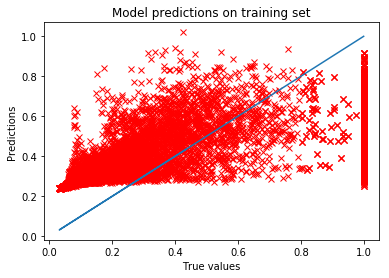

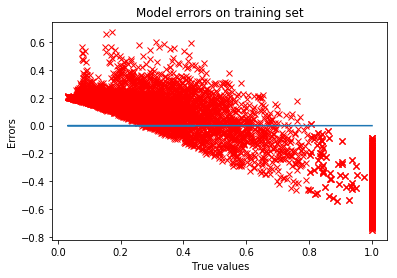

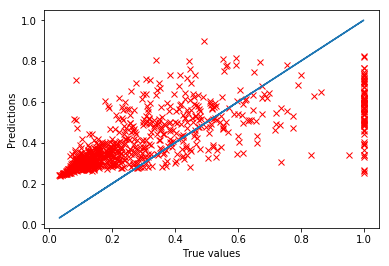

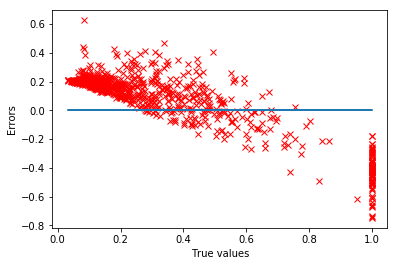

In [14]:
print("Predictions on training set...")
predictions = linearModel.predict(X)
plt.plot(y, predictions, 'rx')
plt.plot(y, y)
plt.title("Model predictions on training set")
plt.xlabel("True values"); plt.ylabel("Predictions")
plt.show()

plt.plot(y, predictions-y, 'rx')
plt.plot(y, 0.*y)
plt.xlabel("True values"); plt.ylabel("Errors")
plt.title("Model errors on training set")
plt.show()



predictions = linearModel.predict(X_test)
plt.plot(y_test, predictions, 'rx')
plt.plot(y_test, y_test)
plt.xlabel("True values"); plt.ylabel("Predictions")
plt.show()


plt.plot(y_test, predictions-y_test, 'rx')
plt.plot(y_test, 0.*y_test)
plt.xlabel("True values"); plt.ylabel("Errors")
plt.show()

Things didn't actually change all that much. I wonder how much of this is a shortcoming of linear regression, and how much is just this one particular case. 

__In any case, we will continue using the supplemented training data with the duplicated points at large suitability scores.__

In [29]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from tqdm import tqdm

cv = 5 # Number of folds for k-fold cross validation
nArr = np.arange(n_nbrs)
alphaArr = np.array([0., 0.01,0.1, 1.0,10. ])
featFunList = [dist_n, dist_0_n, prox_n, prox_0_n]

cvalScoreArr_train_MSE = np.zeros((len(featFunList), nArr.size, alphaArr.size))
cvalScoreArr_train_R2 = np.zeros((len(featFunList), nArr.size, alphaArr.size))
cvalScoreArr_valid_MSE = np.zeros((len(featFunList), nArr.size, alphaArr.size))
cvalScoreArr_valid_R2 = np.zeros((len(featFunList), nArr.size, alphaArr.size))
scoringMetrics = ['neg_mean_squared_error', 'neg_median_absolute_error', 'r2']

resultList = []
coeffList = []

for i0 in range(len(featFunList)):
    featFun = featFunList[i0]
    for i1 in tqdm(range(nArr.size)):
        n = nArr[i1]

        X = featureVector(df_train, featureFun=featFun, n=n)
        y = labelArr(df_train)
        X_test = featureVector(df_test, featureFun=featFun, n=n)
        y_test = labelArr(df_test)
        
        for i2 in range(alphaArr.size):
            alpha = alphaArr[i2]
            # Do a regression without cross validation (on full training set) to store coefficients
            if alpha == 0.: 
                linearModel = LinearRegression().fit(X,y)
            else :
                linearModel = Lasso(alpha=alpha).fit(X,y)
            coeffs = [linearModel.intercept_] + list(linearModel.coef_.flatten())
            coeffList.append(np.array(coeffs))
        
            # Redefine linear model and start crossvalidation to get accuracy metrics
            if alpha ==0.: linearModel = LinearRegression()
            else : linearModel = Lasso(alpha=alpha)
            
            cv_results = cross_validate(linearModel, X, y, cv=cv, scoring=scoringMetrics, return_train_score=True)
            cvalScoreArr_train_MSE[i0,i1,i2] = np.mean(cv_results['train_neg_mean_squared_error'])
            cvalScoreArr_train_R2[i0,i1,i2] = np.mean(cv_results['train_r2'])
            cvalScoreArr_valid_MSE[i0,i1,i2] = np.mean(cv_results['test_neg_mean_squared_error'])
            cvalScoreArr_valid_R2[i0,i1,i2] = np.mean(cv_results['test_r2'])
            
            resultList.append(cv_results) # Keep these for later use if needed


100%|██████████| 10/10 [00:09<00:00,  1.08s/it]


In [30]:
featFunListStr = ['dist_n', 'dist_0_n', 'prox_n', 'prox_0_n']

meanScores0 = cvalScoreArr_valid_R2
for i2 in range(alphaArr.size):
    meanScores = meanScores0[:,:,i2]
    alpha = alphaArr[i2]
    print()
    print("Average cross validation R-Squared (validation) for alpha={:5.2f}...".format(alpha))
    print("     {:8s} | {:8s} | {:8s} | {:8s} ".format(*tuple(featFunListStr)) )
    print("              |          |          |          ")
    for i1 in range(nArr.size):
        printStr = "n={:2d}:".format(nArr[i1]) + \
                "  {:4.3f}  |".format(meanScores[0,i1]) + \
                "  {:4.3f}   |".format(meanScores[1,i1]) + \
                "  {:4.3f}   |".format(meanScores[2,i1]) + \
                "  {:4.3f}".format(meanScores[3,i1])

        print(printStr)




Average cross validation R-Squared (validation) for alpha= 0.00...
     dist_n   | dist_0_n | prox_n   | prox_0_n 
              |          |          |          
n= 0:  0.377  |  0.377   |  0.531   |  0.531
n= 1:  0.389  |  0.411   |  0.509   |  0.550
n= 2:  0.388  |  0.437   |  0.484   |  0.560
n= 3:  0.388  |  0.445   |  0.470   |  0.566
n= 4:  0.389  |  0.467   |  0.458   |  0.570
n= 5:  0.397  |  0.487   |  0.454   |  0.572
n= 6:  0.397  |  0.491   |  0.447   |  0.576
n= 7:  0.397  |  0.498   |  0.445   |  0.577
n= 8:  0.418  |  0.509   |  0.443   |  0.577
n= 9:  0.415  |  0.513   |  0.439   |  0.577

Average cross validation R-Squared (validation) for alpha= 0.01...
     dist_n   | dist_0_n | prox_n   | prox_0_n 
              |          |          |          
n= 0:  0.375  |  0.375   |  0.495   |  0.495
n= 1:  0.386  |  0.401   |  0.465   |  0.498
n= 2:  0.385  |  0.414   |  0.431   |  0.498
n= 3:  0.388  |  0.419   |  0.406   |  0.498
n= 4:  0.386  |  0.427   |  0.386   |  0.4

Ok, so the regularization is pointless. It's a good thing these computations were cheap, or I'd be kicking myself for blindly running all of those cases.

The prox_n and prox_0_n cases do much better than dist_n and dist_0_n cases. This isn't surprising because the output is bounded by 0,1, and the distance features can get a bit out of scale. Let's have a look at the coefficients for the two best cases for prox_n and prox_0_n. For prox_n, this is n=0,1. For prox_0_n, this is n=8,9. 

In [34]:
# Indices for prox_n, n=0,1, and alpha = 0.:
case1 = np.ravel_multi_index((2,0,0), (len(featFunList),nArr.size,alphaArr.size))
case2 = np.ravel_multi_index((2,1,0), (len(featFunList),nArr.size,alphaArr.size))
# Indices for prox_0_n, n=8,9:
case3 = np.ravel_multi_index((3,8,0), (len(featFunList),nArr.size,alphaArr.size))
case4 = np.ravel_multi_index((3,9,0), (len(featFunList),nArr.size,alphaArr.size))

# The coefficients are available in coeffList.
coef_case1 = coeffList[case1]
coef_case2 = coeffList[case2]
coef_case3 = coeffList[case3]
coef_case4 = coeffList[case4]

print("Coefficients for prox_n with n=0 with validation R2: {:4.3f}".format(cvalScoreArr_valid_R2[2,0,0]))
print(tuple(zip(['intercept']+venueCats_sans_sports, np.round(coef_case1,3) )))
print()
print("Coefficients for prox_n with n=1 with validation R2: {:4.3f}".format(cvalScoreArr_valid_R2[2,1,0]))
print(tuple(zip(['intercept']+venueCats_sans_sports, np.round(coef_case2,3) )))

print();print()
print("Coefficients for prox_0_n with n=8 with validation R2: {:4.3f}".format(cvalScoreArr_valid_R2[3,8,0]))
print("Intercept:", coef_case3[0])
for i3 in range(len(venueCats_sans_sports)):
    print("{:12s}".format(venueCats_sans_sports[i3]), np.round(coef_case3[1+8*i3:1+8*(i3+1)], 2) )
    
print();print()
print("Coefficients for prox_0_n with n=9 with validation R2: {:4.3f}".format(cvalScoreArr_valid_R2[3,9,0]))
print("Intercept:", coef_case4[0])
for i3 in range(len(venueCats_sans_sports)):
    print("{:12s}".format(venueCats_sans_sports[i3]), np.round(coef_case4[1+8*i3:1+8*(i3+1)], 2) )

Coefficients for prox_n with n=0 with validation R2: 0.531
(('intercept', -0.064), ('banks', 0.265), ('cinemas', -0.126), ('colleges', 0.455), ('gyms', 0.343), ('hospitals', 0.047), ('pubs', -0.089), ('restaurants', 0.408), ('schools', 0.05), ('supermarkets', 0.156))

Coefficients for prox_n with n=1 with validation R2: 0.509
(('intercept', -0.016), ('banks', 0.25), ('cinemas', -0.156), ('colleges', 0.583), ('gyms', 0.271), ('hospitals', -0.079), ('pubs', 0.062), ('restaurants', 0.37), ('schools', 0.021), ('supermarkets', 0.356))


Coefficients for prox_0_n with n=8 with validation R2: 0.577
Intercept: -0.06301367083804682
banks        [ 0.34  0.15 -0.4   0.58 -0.83  0.48 -0.36  0.44]
cinemas      [-0.32 -0.16 -0.12 -0.06 -0.    0.31  0.02 -0.36]
colleges     [-0.7   1.03  0.26  0.31 -0.23  0.28  0.06  0.37]
gyms         [-0.36 -0.79  0.5   0.35 -0.04  0.03 -0.09  0.08]
hospitals    [-0.11  0.27 -0.03  0.34  0.1  -0.04  0.08 -0.64]
pubs         [ 0.41 -0.6   0.17  0.27  0.31 -0.25  0.2

The coefficients for prox_n are easily interpreted. Banks, colleges, gyms, restaurants, and supermarkets in the vicinity of a location make it more suitable. Cinemas, for some reason, make locations unsuitable. Hospitals, pubs, and schools don't seem to be important. It would be nice to look at the p-values for these coefficients (for null hypothesis that they are zero). That's for a different time. 

For prox_0_n, things are messy. Coefficients keep switching signs. Well, what else can we expect. There's lots of locations, but the target variable is bounded between 0 and 1. Things might start making more sense when we use a sigmoid-like activation function. We'll do that next in the [Single Layer Perceptron](#Single-Layer-Perceptron) section. But before we go, let's visualize the errors for the four cases above. 

R2 (test) for case1:  0.44693664097431385
R2 (test) for case2:  0.4418584069279622
R2 (test) for case3:  0.5003199835477259
R2 (test) for case4:  0.5050929257214647


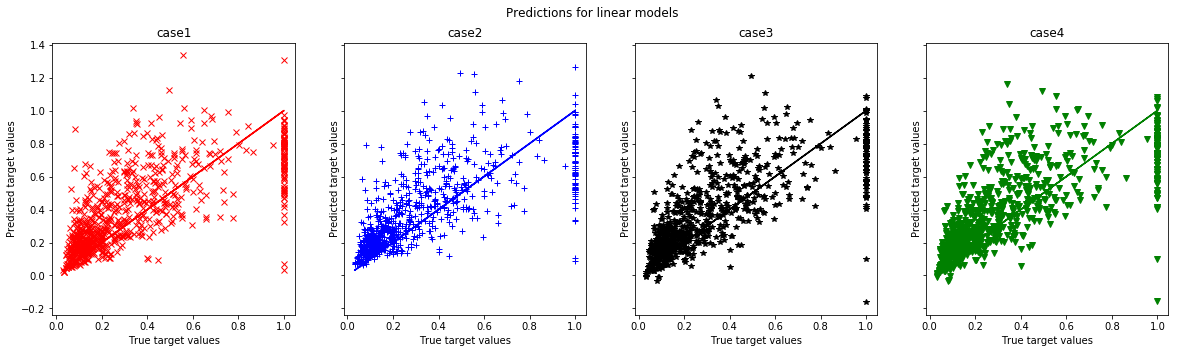

In [32]:
y_test = labelArr(df_test)

# Case 1:
X_test = featureVector(df_test, featureFun=prox_n, n=0)
predictions =  ( X_test @ coef_case1[1:].reshape(-1,1) ) + coef_case1[0]  # feature*weight + intercept
predictions_1 = predictions.flatten()
errors_1 = predictions_1 - y_test
print("R2 (test) for case1: ", r2_score(y_test, predictions_1))

# Case 2:
X_test = featureVector(df_test, featureFun=prox_n, n=1)
predictions =  ( X_test @ coef_case2[1:].reshape(-1,1) ) + coef_case2[0]  # feature*weight + intercept
predictions_2 = predictions.flatten()
errors_2 = predictions_2 - y_test
print("R2 (test) for case2: ", r2_score(y_test, predictions_2))


# Case 3:
X_test = featureVector(df_test, featureFun=prox_0_n, n=8)
predictions =  ( X_test @ coef_case3[1:].reshape(-1,1) ) + coef_case3[0]  # feature*weight + intercept
predictions_3 = predictions.flatten()
errors_3 = predictions_3 - y_test
print("R2 (test) for case3: ", r2_score(y_test, predictions_3))

# Case 4:
X_test = featureVector(df_test, featureFun=prox_0_n, n=9)
predictions =  ( X_test @ coef_case4[1:].reshape(-1,1) ) + coef_case4[0]  # feature*weight + intercept
predictions_4 = predictions.flatten()
errors_4 = predictions_4 - y_test
print("R2 (test) for case4: ", r2_score(y_test, predictions_4))

f, axArr = plt.subplots(1,4, sharey='all',figsize=(20,5))
f.suptitle('Predictions for linear models')
axArr[0].plot(y_test, predictions_1, 'rx')
axArr[0].plot(y_test,y_test,'r-'); axArr[0].set_title("case1")
axArr[0].set_xlabel("True target values"); axArr[0].set_ylabel("Predicted target values")

axArr[1].plot(y_test, predictions_2, 'b+')
axArr[1].plot(y_test,y_test,'b-'); axArr[1].set_title("case2")
axArr[1].set_xlabel("True target values"); axArr[1].set_ylabel("Predicted target values")

axArr[2].plot(y_test, predictions_3, 'k*')
axArr[2].plot(y_test,y_test,'k-'); axArr[2].set_title("case3")
axArr[2].set_xlabel("True target values"); axArr[2].set_ylabel("Predicted target values")

axArr[3].plot(y_test, predictions_4, 'gv')
axArr[3].plot(y_test,y_test,'g-'); axArr[3].set_title("case4")
axArr[3].set_xlabel("True target values"); axArr[3].set_ylabel("Predicted target values")
plt.show()


The simple linear regression isn't too bad in explaining the locational dependence. It captures 50% of the variation in suitability scores. The prox_0_n features (with n=8,9) have test $R^2$ of 0.50 compared to 0.45 for prox_n with n=0.That is, just the proximity to the closest venue explains 45% of the variation. And the cofficients for this case are easily interpreted. The $R^2$ from cross validation were higher, $0.58$ for prox_0_n cases and $0.53$ and $0.51$ for the prox_n cases. This difference arises because the training/validation data has duplicated datapoints corresponding to $S \geq 0.8$. These datapoints were not added to the test set. 

Let's have a look at the coefficients again:

(('intercept', -0.064), ('banks', 0.265), ('cinemas', -0.126), ('colleges', 0.455), ('gyms', 0.343), ('hospitals', 0.047), ('pubs', -0.089), ('restaurants', 0.408), ('schools', 0.05), ('supermarkets', 0.156))

The intercept is slightly negative, but still close to zero. This is a desirable quality. We don't want the suitability score to be negative in remote locations. It can't be significantly positive either, because then remote locations will have a positive bias for suitability score. 

Proximity to cinemas is generally a bad choice for sports facilities, as seen from the negative coefficient for cinemas. The coefficient is not too large though. 

The largest positive coefficients are, in decreasing order, for colleges, restaurants, gyms, banks, and supermarkets. Colleges tend to have sports facilities associated with them. It is not clear if these facilities are profitable, but that is what the training data has. Restaurants, banks, and supermarkets represent commercial centers, while gyms represent physically active demographics. Hospitals, pubs, and schools don't seem to significantly affect suitability scores. 

# Single Layer Perceptron

As before, we will first look at a simple case, understand how it works, and then move on to cross validation to optimize over some hyperparameters. 

__Note: We will use sklearn's MLPRegressor. There is a case to be made for MLPClassifier, saying locations should either be suitable or unsuitable. After the mess that was the logistic classifier (in the previous notebook), I'm now more inclide to match suitability score instead of a probability of having a suitable location.__

For the first simple case, I'll use a hidden layer with just 1 unit and a sigmoid activation. I will not modify any of the default parameters set for MLPRegressor. For features, I will use prox_n with n=0. I'll also set random_state so that results are kinda-sorta replicable. Let's see how that goes. 

In [23]:
from sklearn.neural_network import MLPRegressor

X = featureVector(df_train, featureFun=prox_n, n=0)
y = labelArr(df_train)
SLPmodel = MLPRegressor(hidden_layer_sizes=(1,), activation='logistic' , random_state=0).fit(X,y)

X_test = featureVector(df_test, featureFun=prox_n, n=0)
y_test = labelArr(df_test)
print("R2 score:", SLPmodel.score(X_test,y_test))

R2 score: 0.4521477633904545


We see a miniscule improvement in the R2 score. This is due to the activation function, which was missing previously.  
Next, let's look at the errors and predictions. And the coefficients as well.

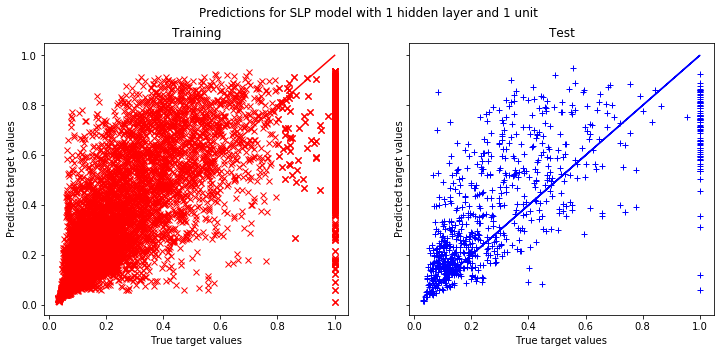

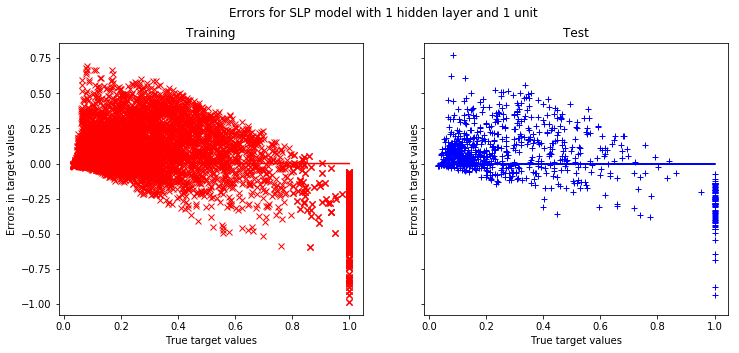

In [20]:
predictions = SLPmodel.predict(X)
predictions_test = SLPmodel.predict(X_test)
errors = predictions - y
errors_test = predictions_test - y_test

f, axArr = plt.subplots(1,2, sharey='all',figsize=(12,5))
f.suptitle('Predictions for SLP model with 1 hidden layer and 1 unit')
axArr[0].plot(y, predictions, 'rx')
axArr[0].plot(y,y,'r-'); axArr[0].set_title("Training")
axArr[0].set_xlabel("True target values"); axArr[0].set_ylabel("Predicted target values")

axArr[1].plot(y_test, predictions_test, 'b+')
axArr[1].plot(y_test,y_test,'b-'); axArr[1].set_title("Test")
axArr[1].set_xlabel("True target values"); axArr[1].set_ylabel("Predicted target values")
plt.show()

f, axArr = plt.subplots(1,2, sharey='all',figsize=(12,5))
f.suptitle('Errors for SLP model with 1 hidden layer and 1 unit')
axArr[0].plot(y, errors, 'rx')
axArr[0].plot(y,0.*y,'r-'); axArr[0].set_title("Training")
axArr[0].set_xlabel("True target values"); axArr[0].set_ylabel("Errors in target values")

axArr[1].plot(y_test, errors_test, 'b+')
axArr[1].plot(y_test,0.*y_test,'b-'); axArr[1].set_title("Test")
axArr[1].set_xlabel("True target values"); axArr[1].set_ylabel("Errors in target values")
plt.show()





Do these plots look better than the linear regression cases? Not very much. There is a miniscule improvement in R2 compared to the prox_n case in linear regression. Let's have a look at the coefficients for the lone hidden unit in the only hidden layer. 

In [21]:
coeffs = [SLPmodel.intercepts_[0][0]] + list(SLPmodel.coefs_[0].flatten())
print(tuple(zip(['intercept']+venueCats_sans_sports, coeffs)))

(('intercept', -1.281428905725295), ('banks', 0.8304888157494614), ('cinemas', 0.09481925255577724), ('colleges', 1.1851565925273155), ('gyms', 0.874367239496634), ('hospitals', 0.38295299945739497), ('pubs', 0.21756232411060641), ('restaurants', 0.8551288693582907), ('schools', 0.14564540378787183), ('supermarkets', 0.9487873711765882))


An obvious difference from the linear regression cases is that the intercept is now significantly negative. This is acceptable because we have activation functions that map negative numbers back to zero. 

The coefficients have also changed. They are all positive now, including for 'cinemas', and they are greater than before. They do maintain some approximate ordering though. Colleges, supermarkets, gyms, restaurants, and banks are still the most dominant. Pubs, hospitals, and schools still have smaller coefficients, and cinemas is now close to zero. 

There's also the intercept and coefficient for the output layer, but there isn't an activation function that follows. The output layer essentially scales the result. We'll not pay any attention to it. 

Next, we change the number of units in the single hidden layer, and the random_state used for initialization. We will ignore other parameters related to regularization and optimization. We will keep sigmoid (logistic) activation function because the target values have to be between 0 and 1. 

In [11]:
n_unitsArr = np.array([1,5,10,20])
featFunList = [dist_n, dist_0_n, prox_n, prox_0_n]

from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from tqdm import tqdm

cv = 5 # Number of folds for k-fold cross validation
featFunList = [dist_n, dist_0_n, prox_n, prox_0_n]
nArr = np.arange(10, dtype=int)

cvalScoreArr_train_MSE = np.zeros((len(featFunList), nArr.size, n_unitsArr.size))
cvalScoreArr_train_R2 = np.zeros((len(featFunList), nArr.size, n_unitsArr.size))
cvalScoreArr_valid_MSE = np.zeros((len(featFunList), nArr.size, n_unitsArr.size))
cvalScoreArr_valid_R2 = np.zeros((len(featFunList), nArr.size, n_unitsArr.size))
scoringMetrics = ['neg_mean_squared_error', 'r2']

bestModelList = []   # Store best models over different random states for each featFun, n_nbrs, n_units

for i0 in range(len(featFunList)):
    featFun = featFunList[i0]
    for i1 in tqdm(range(nArr.size)):
        n = nArr[i1]

        X = featureVector(df_train, featureFun=featFun, n=n)
        y = labelArr(df_train)
        X_test = featureVector(df_test, featureFun=featFun, n=n)
        y_test = labelArr(df_test)
        
        for i2 in range(n_unitsArr.size):
            n_units = n_unitsArr[i2]
            for randState in range(11):
                SLPmodel = MLPRegressor(hidden_layer_sizes=(n_units,), 
                                        activation='logistic', random_state=randState)
                
                cv_results = cross_validate(SLPmodel, X, y, cv=cv, scoring=scoringMetrics, return_train_score=True)
                
                if randState == 0 :
                    best_r2 = np.mean(cv_results['test_r2'])
                
                if np.mean(cv_results['test_r2']) >= best_r2 :
                    bestModel = SLPmodel.fit(X,y)
                    best_r2 = np.mean(cv_results['test_r2'])
                    best_results = cv_results
            
            cvalScoreArr_train_MSE[i0,i1,i2] = np.mean(best_results['train_neg_mean_squared_error'])
            cvalScoreArr_train_R2[i0,i1,i2] = np.mean(best_results['train_r2'])
            cvalScoreArr_valid_MSE[i0,i1,i2] = np.mean(best_results['test_neg_mean_squared_error'])
            cvalScoreArr_valid_R2[i0,i1,i2] = np.mean(best_results['test_r2'])
            
            bestModelList.append(bestModel)
            


 60%|██████    | 6/10 [20:38<14:53, 223.39s/it]C:\Users\Sabarish\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 70%|███████   | 7/10 [25:33<12:14, 244.87s/it]C:\Users\Sabarish\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Sabarish\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 80%|████████  | 8/10 [30:57<08:57, 268.82s/it]C:\Users\Sabarish\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.

In [12]:
featFunListStr = ['dist_n', 'dist_0_n', 'prox_n', 'prox_0_n']

meanScores0 = cvalScoreArr_valid_R2
for i2 in range(n_unitsArr.size):
    meanScores = meanScores0[:,:,i2]
    n_units = n_unitsArr[i2]
    print()
    print("Average cross validation R-Squared (validation) for n_units={:3d}...".format(n_units))
    print("     {:8s} | {:8s} | {:8s} | {:8s} ".format(*tuple(featFunListStr)) )
    print("              |          |          |          ")
    for i1 in range(nArr.size):
        printStr = "n={:2d}:".format(nArr[i1]) + \
                "  {:4.3f}  |".format(meanScores[0,i1]) + \
                "  {:4.3f}   |".format(meanScores[1,i1]) + \
                "  {:4.3f}   |".format(meanScores[2,i1]) + \
                "  {:4.3f}".format(meanScores[3,i1])

        print(printStr)




Average cross validation R-Squared (validation) for n_units=  1...
     dist_n   | dist_0_n | prox_n   | prox_0_n 
              |          |          |          
n= 0:  0.487  |  0.487   |  0.537   |  0.537
n= 1:  0.456  |  0.523   |  0.525   |  0.555
n= 2:  0.445  |  0.539   |  0.500   |  0.564
n= 3:  0.450  |  -0.024   |  0.481   |  0.551
n= 4:  0.445  |  0.541   |  0.468   |  0.580
n= 5:  0.442  |  0.550   |  0.461   |  -0.040
n= 6:  0.441  |  -0.009   |  0.269   |  0.573
n= 7:  0.438  |  -0.004   |  0.022   |  0.583
n= 8:  0.437  |  -0.001   |  0.020   |  0.583
n= 9:  0.434  |  -0.001   |  0.018   |  0.586

Average cross validation R-Squared (validation) for n_units=  5...
     dist_n   | dist_0_n | prox_n   | prox_0_n 
              |          |          |          
n= 0:  0.524  |  0.524   |  0.522   |  0.522
n= 1:  0.529  |  0.574   |  0.503   |  0.550
n= 2:  0.513  |  0.586   |  0.476   |  0.561
n= 3:  0.485  |  0.535   |  0.463   |  0.556
n= 4:  0.482  |  0.542   |  0.453   

Some of the cases with dist_0_n features did not converge with the default number of iterations when the number of hidden units was low. 

dist_n and prox_n get worse with increasing n, as we've already noted from linear regression. This is especially pronounced for prox_n with 1 unit in the hidden layer. Throwing more units at it doesn't make things better. 

prox_0_n gets better with increasing n, and increasing the number of hidden units also improves the model. 

dist_0_n is the clear winner in the SLP. When we allow enough units in the hidden layer, it does much better than the other types of features. It doesn't do so well with very few hidden units though, in which case it also runs into convergence issues. 

In linear regression, dist_n and dist_0_n didn't do so well. This must be because prox_n and prox_0_n had a nice scaling that played well with the target scores. With this SLP, the sigmoid activation makes up for this shortcoming in the dist_n and dist_0_n features. SLP even makes dist_0_n much better because distances show greater range, thus allowing for very clear separation in venues that are just bit farther and venues that are very far. 

I'll run dist_0_n(n=5,10) once again, this time with more hidden units and allowing for more iterations. Let's see how that goes. 

In [27]:
n_unitsArr = np.array([20,50,100])
featFunList = [dist_0_n]

from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm

cv = 5 # Number of folds for k-fold cross validation
nArr = np.array([5,10])

cvalScoreArr_train_MSE = np.zeros((len(featFunList), nArr.size, n_unitsArr.size))
cvalScoreArr_train_R2 = np.zeros((len(featFunList), nArr.size, n_unitsArr.size))
cvalScoreArr_valid_MSE = np.zeros((len(featFunList), nArr.size, n_unitsArr.size))
cvalScoreArr_valid_R2 = np.zeros((len(featFunList), nArr.size, n_unitsArr.size))
scoringMetrics = ['neg_mean_squared_error', 'r2']

bestModelList = []   # Store best models over different random states for each featFun, n_nbrs, n_units

for i0 in range(len(featFunList)):
    featFun = featFunList[i0]
    for i1 in tqdm(range(nArr.size)):
        n = nArr[i1]

        X = featureVector(df_train, featureFun=featFun, n=n)
        y = labelArr(df_train)
        X_test = featureVector(df_test, featureFun=featFun, n=n)
        y_test = labelArr(df_test)
        
        for i2 in range(n_unitsArr.size):
            n_units = n_unitsArr[i2]
            for randState in range(5):
                SLPmodel = MLPRegressor(hidden_layer_sizes=(n_units,), max_iter=1000,
                                        activation='logistic', random_state=randState)
                
                cv_results = cross_validate(SLPmodel, X, y, cv=cv, 
                                            scoring=scoringMetrics, return_train_score=True)
                
                if randState == 0 :
                    best_r2 = np.mean(cv_results['test_r2'])
                
                if np.mean(cv_results['test_r2']) >= best_r2 :
                    bestModel = SLPmodel.fit(X,y)
                    best_r2 = np.mean(cv_results['test_r2'])
                    best_results = cv_results
            
            cvalScoreArr_train_MSE[i0,i1,i2] = np.mean(best_results['train_neg_mean_squared_error'])
            cvalScoreArr_train_R2[i0,i1,i2] = np.mean(best_results['train_r2'])
            cvalScoreArr_valid_MSE[i0,i1,i2] = np.mean(best_results['test_neg_mean_squared_error'])
            cvalScoreArr_valid_R2[i0,i1,i2] = np.mean(best_results['test_r2'])
            
            
            bestModelList.append(bestModel)
            


100%|██████████| 2/2 [12:09<00:00, 333.31s/it]


In [28]:
meanScores = cvalScoreArr_train_R2
print()
print("Average cross validation R-Squared (train)")
print("n_units:{:8d} | {:8d} | {:8d}".format(*n_unitsArr) )
print("                 |          |         ")
for i1 in range(nArr.size):
    printStr = "n={:2d}  : ".format(nArr[i1]) + \
            "  {:4.3f}  |".format(meanScores[0,i1,0]) + \
            "  {:4.3f}   |".format(meanScores[0,i1,1]) + \
            "  {:4.3f}   |".format(meanScores[0,i1,2])

    print(printStr)

meanScores = cvalScoreArr_test_R2
print()
print("Average cross validation R-Squared (validation)")
print("n_units:{:8d} | {:8d} | {:8d}".format(*n_unitsArr) )
print("                 |          |           ")
for i1 in range(nArr.size):
    printStr = "n={:2d}  : ".format(nArr[i1]) + \
            "  {:4.3f}  |".format(meanScores[0,i1,0]) + \
            "  {:4.3f}   |".format(meanScores[0,i1,1]) + \
            "  {:4.3f}   |".format(meanScores[0,i1,2]) 

    print(printStr)




Average cross validation R-Squared (train)
n_units:      20 |       50 |      100
                 |          |         
n= 5  :   0.705  |  0.718   |  0.714   |
n=10  :   0.750  |  0.761   |  0.768   |

Average cross validation R-Squared (validation)
n_units:      20 |       50 |      100
                 |          |           
n= 5  :   0.687  |  0.698   |  0.691   |
n=10  :   0.721  |  0.732   |  0.735   |


The best $R^2$ was for n_units=100. Let's see how far we can push this without overfitting.

In [13]:
n_unitsArr = np.arange(200, 501,100)
featFunList = [dist_0_n]

from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm

cv = 5 # As before...
nArr = np.array([10]) #Just for 10 nearest neighbors

cvalScoreArr_train_MSE = np.zeros((len(featFunList), nArr.size, n_unitsArr.size))
cvalScoreArr_train_R2 = np.zeros((len(featFunList), nArr.size, n_unitsArr.size))
cvalScoreArr_valid_MSE = np.zeros((len(featFunList), nArr.size, n_unitsArr.size))
cvalScoreArr_valid_R2 = np.zeros((len(featFunList), nArr.size, n_unitsArr.size))
scoringMetrics = ['neg_mean_squared_error', 'r2']

bestModelList_2 = []   # Store best models over different random states for each featFun, n_nbrs, n_units

for i0 in range(len(featFunList)):
    featFun = featFunList[i0]
    for i1 in range(nArr.size):
        n = nArr[i1]

        X = featureVector(df_train, featureFun=featFun, n=n)
        y = labelArr(df_train)
        
        for i2 in tqdm(range(n_unitsArr.size)):
            n_units = n_unitsArr[i2]
            best_r2 = 0.
            for randState in range(5):
                SLPmodel = MLPRegressor(hidden_layer_sizes=(n_units,), max_iter=1000,
                                        activation='logistic', random_state=randState)
                
                cv_results = cross_validate(SLPmodel, X, y, cv=cv, 
                                            scoring=scoringMetrics, return_train_score=True)
                
                if np.mean(cv_results['test_r2']) >= best_r2 :
                    bestModel = SLPmodel.fit(X,y)
                    best_r2 = np.mean(cv_results['test_r2'])
                    best_results = cv_results
            
            cvalScoreArr_train_MSE[i0,i1,i2] = np.mean(best_results['train_neg_mean_squared_error'])
            cvalScoreArr_train_R2[i0,i1,i2] = np.mean(best_results['train_r2'])
            cvalScoreArr_valid_MSE[i0,i1,i2] = np.mean(best_results['test_neg_mean_squared_error'])
            cvalScoreArr_valid_R2[i0,i1,i2] = np.mean(best_results['test_r2'])
            
            
            bestModelList_2.append(bestModel)


100%|██████████| 4/4 [28:27<00:00, 425.67s/it]


In [14]:
print("Average cross validation R-Squared (train) for n=10")
print(tuple(zip(n_unitsArr, cvalScoreArr_train_R2[0,0])))

print()
print("Average cross validation R-Squared (validation) for n=10")
print(tuple(zip(n_unitsArr, cvalScoreArr_valid_R2[0,0])))


Average cross validation R-Squared (train) for n=10
((200, 0.7786321554267776), (300, 0.7587647972112139), (400, 0.7413137983922428), (500, 0.7435501674211741))

Average cross validation R-Squared (validation) for n=10
((200, 0.7427431287108142), (300, 0.7285884684477651), (400, 0.7093098297845069), (500, 0.7089793375290044))


In [15]:
n_unitsArr = np.arange(125,276,25)
featFunList = [dist_0_n]

from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm

cv = 5 # As before...
nArr = np.array([10]) #Just for 10 nearest neighbors

cvalScoreArr_train_MSE = np.zeros((len(featFunList), nArr.size, n_unitsArr.size))
cvalScoreArr_train_R2 = np.zeros((len(featFunList), nArr.size, n_unitsArr.size))
cvalScoreArr_valid_MSE = np.zeros((len(featFunList), nArr.size, n_unitsArr.size))
cvalScoreArr_valid_R2 = np.zeros((len(featFunList), nArr.size, n_unitsArr.size))
scoringMetrics = ['neg_mean_squared_error', 'r2']

bestModelList_3 = []   # Store best models over different random states for each featFun, n_nbrs, n_units

for i0 in range(len(featFunList)):
    featFun = featFunList[i0]
    for i1 in range(nArr.size):
        n = nArr[i1]

        X = featureVector(df_train, featureFun=featFun, n=n)
        y = labelArr(df_train)
        
        for i2 in tqdm(range(n_unitsArr.size)):
            n_units = n_unitsArr[i2]
            best_r2 = 0.
            for randState in range(5):
                SLPmodel = MLPRegressor(hidden_layer_sizes=(n_units,), max_iter=1000,
                                        activation='logistic', random_state=randState)
                
                cv_results = cross_validate(SLPmodel, X, y, cv=cv, 
                                            scoring=scoringMetrics, return_train_score=True)
                
                if np.mean(cv_results['test_r2']) >= best_r2 :
                    bestModel = SLPmodel.fit(X,y)
                    best_r2 = np.mean(cv_results['test_r2'])
                    best_results = cv_results
            
            cvalScoreArr_train_MSE[i0,i1,i2] = np.mean(best_results['train_neg_mean_squared_error'])
            cvalScoreArr_train_R2[i0,i1,i2] = np.mean(best_results['train_r2'])
            cvalScoreArr_valid_MSE[i0,i1,i2] = np.mean(best_results['test_neg_mean_squared_error'])
            cvalScoreArr_valid_R2[i0,i1,i2] = np.mean(best_results['test_r2'])
            
            
            bestModelList_3.append(bestModel)


100%|██████████| 7/7 [33:23<00:00, 301.38s/it]


In [16]:
print("Average cross validation R-Squared (train) for n=10")
print(tuple(zip(n_unitsArr, cvalScoreArr_train_R2[0,0])))

print()
print("Average cross validation R-Squared (validation) for n=10")
print(tuple(zip(n_unitsArr, cvalScoreArr_valid_R2[0,0])))


Average cross validation R-Squared (train) for n=10
((125, 0.8055980536573932), (150, 0.775663868231595), (175, 0.7659021729795716), (200, 0.7786321554267776), (225, 0.7672963497064804), (250, 0.7367936986487982), (275, 0.7572956193529216))

Average cross validation R-Squared (validation) for n=10
((125, 0.7612622634379187), (150, 0.7396162896178642), (175, 0.7342197686469817), (200, 0.7427431287108142), (225, 0.7339371077307641), (250, 0.7109439838627569), (275, 0.726937199469348))


The best $R^2$ is for the SLP with 125 hidden units. This case has a training $R^2$ of 0.81 and a validation $R^2$ of 0.76. These are not bad at all. Unfortunately, it's not easy to make sense of the coefficients of perceptrons. We could try to see what kind of input produces the greatest output, and hence figure out which features are being identified. The way it's done in computer vision. I will not do this here though, not for this capstone project. Some other time, perhaps. 

I will plot the predictions and errors though, for the n=10, n_units=50 case. 

R2 on full training set without cross validation: 0.7451831216087461
R2 on test set: 0.6802821610653167


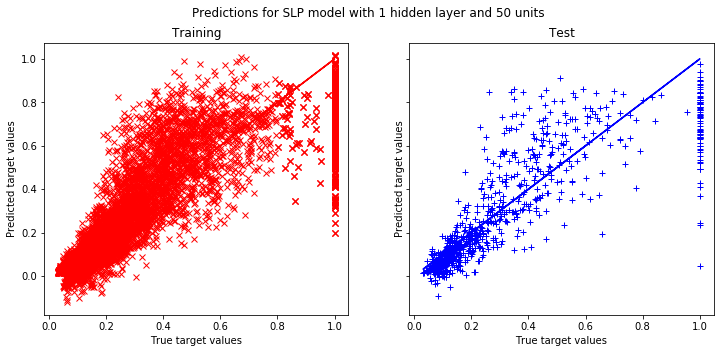

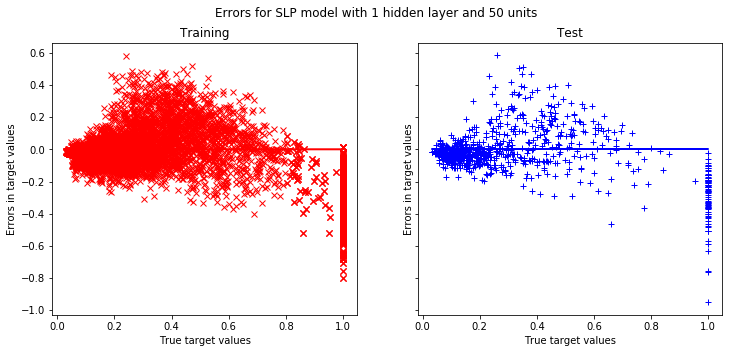

In [18]:
SLPmodel = bestModelList_3[0]
X = featureVector(df_train, featureFun=dist_0_n, n=10)
y = labelArr(df_train)
X_test = featureVector(df_test, featureFun=dist_0_n, n=10)
y_test = labelArr(df_test)

predictions = SLPmodel.predict(X)
predictions_test = SLPmodel.predict(X_test)
errors = predictions - y
errors_test = predictions_test - y_test
print("R2 on full training set without cross validation:", r2_score(y,predictions))
print("R2 on test set:", r2_score(y_test,predictions_test))


f, axArr = plt.subplots(1,2, sharey='all',figsize=(12,5))
f.suptitle('Predictions for SLP model with 1 hidden layer and 50 units')
axArr[0].plot(y, predictions, 'rx')
axArr[0].plot(y,y,'r-'); axArr[0].set_title("Training")
axArr[0].set_xlabel("True target values"); axArr[0].set_ylabel("Predicted target values")

axArr[1].plot(y_test, predictions_test, 'b+')
axArr[1].plot(y_test,y_test,'b-'); axArr[1].set_title("Test")
axArr[1].set_xlabel("True target values"); axArr[1].set_ylabel("Predicted target values")
plt.show()

f, axArr = plt.subplots(1,2, sharey='all',figsize=(12,5))
f.suptitle('Errors for SLP model with 1 hidden layer and 50 units')
axArr[0].plot(y, errors, 'rx')
axArr[0].plot(y,0.*y,'r-'); axArr[0].set_title("Training")
axArr[0].set_xlabel("True target values"); axArr[0].set_ylabel("Errors in target values")

axArr[1].plot(y_test, errors_test, 'b+')
axArr[1].plot(y_test,0.*y_test,'b-'); axArr[1].set_title("Test")
axArr[1].set_xlabel("True target values"); axArr[1].set_ylabel("Errors in target values")
plt.show()





An $R^2$ of 0.68 on the test set. This is significantly lower than the $R^2$ on the training set of 0.75 or the $R^2$ during cross-validation of 0.76. This drop in $R^2$ is because of the difference in distributions - the training/validation data set was supplemented with extra datapoints with $S \geq 0.8$. In any case, $R^2$ of 0.57 is not bad at all. And unlike the linear regression cases, the predictions here actually start at $y=0$. 

__The SLP significantly outperforms the linear regression models. The linear regression models produced a best test $R^2$ of 0.5, while the SLP above produces an $R^2$ of 0.68.__

We still have the issue of the $S=1$ cases in the training/test sets having significant errors. This is expected. We argued earlier that the existing facilities aren't necessarily optimized by location. We assigned $S=1$ just to make sense of the training data. 

With that, we conclude the section on SLPs. Next, let's try a few MLPs, just for fun. 

# Multi Layer Perceptron

The features from dist_0_n(n=10) have clearly outperformed others in the SLP. We will use these features for MLPs as well. The SLP above has already done a fair job with the predictions. For the MLPs, we will not go overboard. Just a simple model with 3 hidden layers; 3 layers because, reasons. We will not try to optimize over number of hidden units. We'll just go with (125, 25, 5), because, reasons. We will try a few different random states. Other than that, we will not tweak any of the default hyperparameters. 

Since we are not trying to optimize for any hyperparameters, we don't need cross-validation. Just the training set and the test set will do. Here goes...

In [19]:
X = featureVector(df_train, featureFun=dist_0_n, n=10)
y = labelArr(df_train)
X_test = featureVector(df_test, featureFun=dist_0_n, n=10)
y_test = labelArr(df_test)

r2_0 = 0.
for randState in tqdm(range(5)):
    MLPmodel = MLPRegressor(hidden_layer_sizes=(125,25,5), max_iter=2000,
                                        activation='logistic', random_state=randState).fit(X,y)
    
    predictions = MLPmodel.predict(X_test)
    r2 = r2_score(y_test, predictions)
    
    if r2 >= r2_0 :
        bestMLPmodel = MLPmodel
        r2_0 = r2


100%|██████████| 5/5 [01:38<00:00, 19.15s/it]


R2 score on full training set: 0.8678551874684732
R2 score on test set: 0.7187804750203832


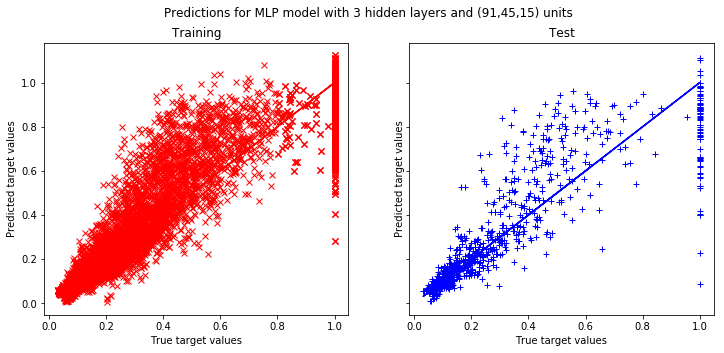

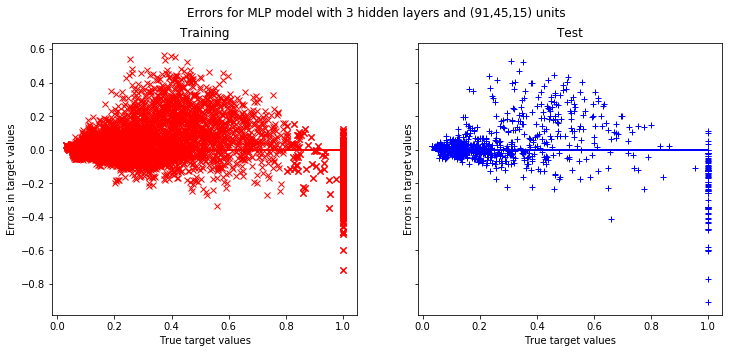

In [20]:
predictions = bestMLPmodel.predict(X)
predictions_test = bestMLPmodel.predict(X_test)
errors = predictions - y
errors_test = predictions_test - y_test
print("R2 score on full training set:", r2_score(y, predictions))
print("R2 score on test set:", r2_score(y_test, predictions_test))


f, axArr = plt.subplots(1,2, sharey='all',figsize=(12,5))
f.suptitle('Predictions for MLP model with 3 hidden layers and (91,45,15) units')
axArr[0].plot(y, predictions, 'rx')
axArr[0].plot(y,y,'r-'); axArr[0].set_title("Training")
axArr[0].set_xlabel("True target values"); axArr[0].set_ylabel("Predicted target values")

axArr[1].plot(y_test, predictions_test, 'b+')
axArr[1].plot(y_test,y_test,'b-'); axArr[1].set_title("Test")
axArr[1].set_xlabel("True target values"); axArr[1].set_ylabel("Predicted target values")
plt.show()

f, axArr = plt.subplots(1,2, sharey='all',figsize=(12,5))
f.suptitle('Errors for MLP model with 3 hidden layers and (91,45,15) units')
axArr[0].plot(y, errors, 'rx')
axArr[0].plot(y,0.*y,'r-'); axArr[0].set_title("Training")
axArr[0].set_xlabel("True target values"); axArr[0].set_ylabel("Errors in target values")

axArr[1].plot(y_test, errors_test, 'b+')
axArr[1].plot(y_test,0.*y_test,'b-'); axArr[1].set_title("Test")
axArr[1].set_xlabel("True target values"); axArr[1].set_ylabel("Errors in target values")
plt.show()





And just like that we went from a test $R^2 = 0.68$ for SLP to a test $R^2=0.72$ for the MLP. I'm satisfied with this MLP. Can we do better by optimizing over hyperparameters for the MLP? Probably. Is it worth the effort considering the mess that is the present dataset? Nope. At least not for now. 

It would be a shame to just leave it like this though. I'll try a few more arrangements. I should be doing cross validation, but I didn't do that for the previous MLP. To be consistent, I'll just do the full training set and the test set without cross validation. 

In [33]:
MLPshapes = [(100,20,5), (50,50,25), (50,50,20,5), (50,25,25,20,5)] 
# I tried to keep the total number of hidden units to 125. Note that this doesn't hold the number of coefficients constant,
#   but I had to have something to aim at. 
# Let's see how these four MLPs compare to the SLP and the previous MLP

X = featureVector(df_train, featureFun=dist_0_n, n=10)
y = labelArr(df_train)
X_test = featureVector(df_test, featureFun=dist_0_n, n=10)
y_test = labelArr(df_test)

bestMLPmodelList = []
for MLPshape in MLPshapes:
    r2_0 = 0.
    for randState in tqdm(range(5)):
        MLPmodel = MLPRegressor(hidden_layer_sizes=MLPshape, max_iter=2000,
                                            activation='logistic', random_state=randState).fit(X,y)

        predictions = MLPmodel.predict(X_test)
        r2 = r2_score(y_test, predictions)

        if r2 >= r2_0 :
            bestMLPmodel = MLPmodel
            r2_0 = r2
    
    bestMLPmodelList.append(bestMLPmodel)


100%|██████████| 5/5 [00:52<00:00,  9.85s/it]




MLP hidden layer sizes: (100, 20, 5)
R2 score on full training set: 0.8461483030246741
R2 score on test set: 0.7413200211121246


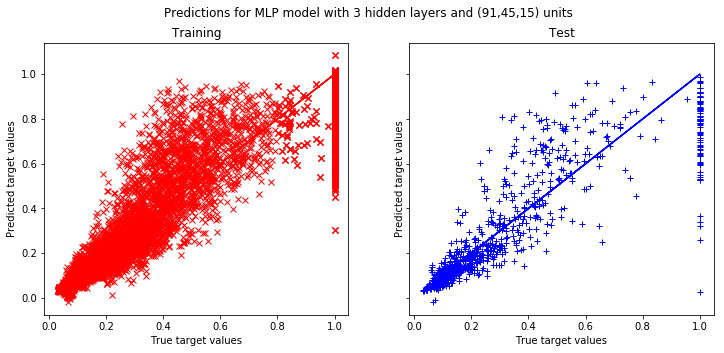

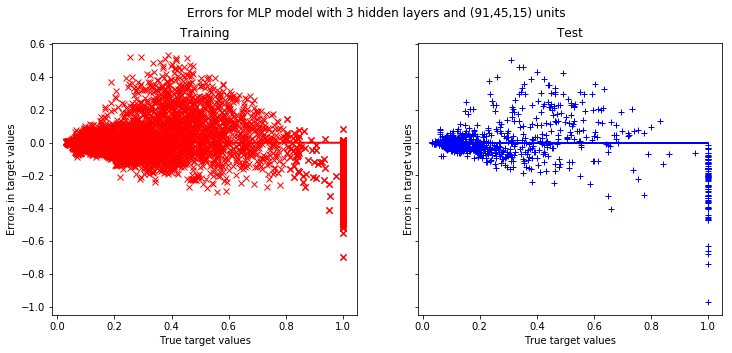



MLP hidden layer sizes: (50, 50, 25)
R2 score on full training set: 0.7922034946010271
R2 score on test set: 0.7009077865017005


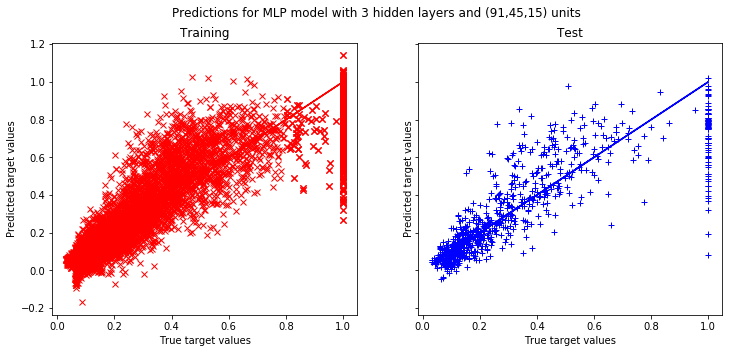

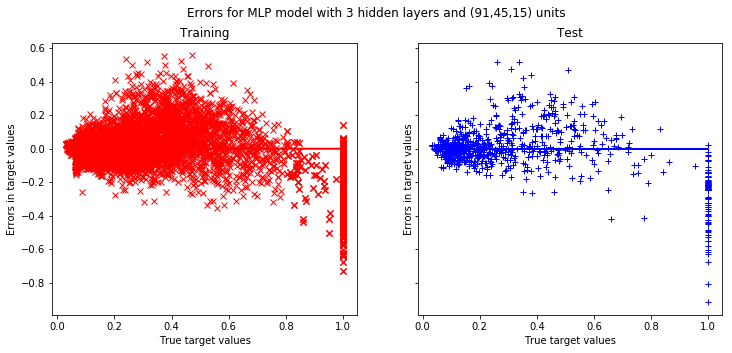



MLP hidden layer sizes: (50, 50, 20, 5)
R2 score on full training set: 0.8768038393236757
R2 score on test set: 0.6961116946123536


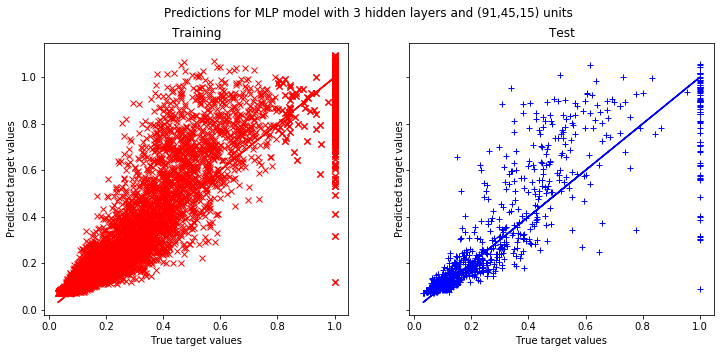

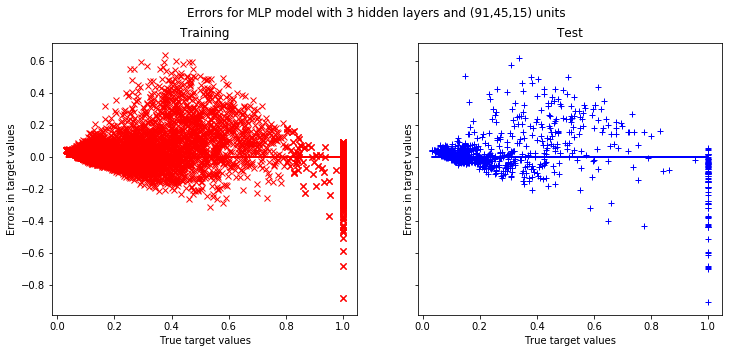



MLP hidden layer sizes: (50, 25, 25, 20, 5)
R2 score on full training set: 0.8148602797318361
R2 score on test set: 0.6679894845422416


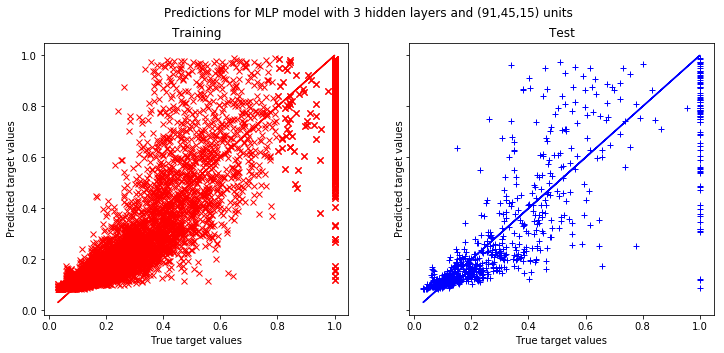

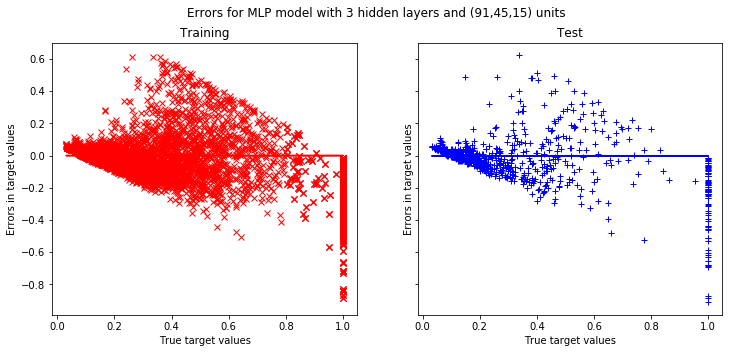

In [35]:
for ind, bestMLPmodel in enumerate(bestMLPmodelList):
    print();print()
    
    print("=============================================================")
    print("MLP hidden layer sizes:", MLPshapes[ind])
    
    predictions = bestMLPmodel.predict(X)
    predictions_test = bestMLPmodel.predict(X_test)
    errors = predictions - y
    errors_test = predictions_test - y_test
    print("R2 score on full training set:", r2_score(y, predictions))
    print("R2 score on test set:", r2_score(y_test, predictions_test))


    f, axArr = plt.subplots(1,2, sharey='all',figsize=(12,5))
    f.suptitle('Predictions for MLP model with 3 hidden layers and (91,45,15) units')
    axArr[0].plot(y, predictions, 'rx')
    axArr[0].plot(y,y,'r-'); axArr[0].set_title("Training")
    axArr[0].set_xlabel("True target values"); axArr[0].set_ylabel("Predicted target values")

    axArr[1].plot(y_test, predictions_test, 'b+')
    axArr[1].plot(y_test,y_test,'b-'); axArr[1].set_title("Test")
    axArr[1].set_xlabel("True target values"); axArr[1].set_ylabel("Predicted target values")
    plt.show()

    f, axArr = plt.subplots(1,2, sharey='all',figsize=(12,5))
    f.suptitle('Errors for MLP model with 3 hidden layers and (91,45,15) units')
    axArr[0].plot(y, errors, 'rx')
    axArr[0].plot(y,0.*y,'r-'); axArr[0].set_title("Training")
    axArr[0].set_xlabel("True target values"); axArr[0].set_ylabel("Errors in target values")

    axArr[1].plot(y_test, errors_test, 'b+')
    axArr[1].plot(y_test,0.*y_test,'b-'); axArr[1].set_title("Test")
    axArr[1].set_xlabel("True target values"); axArr[1].set_ylabel("Errors in target values")
    plt.show()





Good. The first MLP with layer sizes (100,20,5) got to test $R^2$ = 0.74. That should do for now. 

### Save the (100,20,5) MLP model for later.

In [37]:
from joblib import load, dump
bestMLPmodel = bestMLPmodelList[0]

dump(bestMLPmodel, 'MLPmodel.joblib')

['MLPmodel.joblib']

Before we leave, let's have a look at where the errors are the greatest.

In [41]:
def clamp(x): 
  return max(0, min(x, 255))

def rgb2hex(r,g,b):
    return "#{0:02x}{1:02x}{2:02x}".format(clamp(r), clamp(g), clamp(b))

def blueRed(x):
    # Keep x between -0.5, 0.5. -1 is blue, +1 is red
    x = min(x,0.5)
    x = max(x,-0.5)
    if x <= 0:
        r = int(256*(1.+2.*x) )
        b = 256
        g = int(256*(1.+2.*x) )
    else :
        r = 256
        b = int((1.-2.*x)*256)
        g = int((1.-2.*x)*256)
    return rgb2hex(r,g,b)

# Plot first 100 locations in dataset
map_tmp = folium.Map(
    location=[lat_CC, lng_CC], zoom_start=11)



for ind in range(len(df_test)):
    folium.CircleMarker(
        [df_test.iloc[ind,1], df_test.iloc[ind,2]],
        radius=3,
        fill=True,
        fill_color=blueRed( predictions_test[ind] - y_test[ind]),
        color = blueRed( predictions_test[ind] - y_test[ind]),
        fill_opacity=0.7).add_to(map_tmp)

print("Colormap: blue for err=-0.5 and lower, red for err=+0.5 and higher")    
map_tmp

Colormap: blue for err=-0.5 and lower, red for err=+0.5 and higher


There doesn't seem to be any clear geographical bias. I guess we're good to go. 

# Summary

We looked at three kinds of regression models. 

__Simple linear regression__: While training these models, we found that there was a lot more data close to $y \approx 0$, so we supplemented the dataset with a triplicate from $y \geq 0.8$. We did this only for the training/validation set. Subsequent training of linear regression models put the best $R^2$ around 0.5. This $R^2$ was obtained for prox_0_n features, where we use proximities to all 9 or 10 nearest venues of each category in the feature vector. The coefficients belonging to any particular venue category aren't all positive or all negative, but switch signs. 

__Single Layer Perceptron__: A neural network with a single hidden layer does slightly better than simple linear regression, even when just a single hidden unit was used. When the number of hidden units is increased to 125, the test $R^$ goes all the way up to 0.68. The errors aren't quite normally distributed, but they do have a reasonable spread around zero. There is a clear bias at the low and high ends of target values, but this is true for all of the regression models. 

__Multi Layer Perceptron__: A single MLP was trained with 3 hidden layers with (125, 25, 5) hidden units (and 1 unit in the output layer). This MLP produced a test $R^2$ of 0.72, which is a decent fit. I decided to not explore more MLPs. After all, the quality of a model can only be as good as the data used to train it. The data used here is by not perfect by any means, so there is little reason to try and push for even better models. Except I did try a few more arrangements, and the model with (100,20,5) hidden units produced a test $R^2$ of 0.74. And that's the end of it. 

__For the SLP and MLP, we used logistic (sigmoid) activation. I've heard it often said that ReLU activations are better. I couldn't find an off-the-shelf implementation in scikit-learn to have ReLU for hidden layers and Logistic for output layer. This is something worth trying later on.__